In [1]:
# import required Libraries for clustering

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import datetime as dt

import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [2]:
retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
retail.shape

(541909, 8)

In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Data cleaning

In [5]:
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [6]:
# Droping missing rows

retail = retail.dropna()
retail.shape

(406829, 8)

In [7]:
#Changing the datatype of Customer Id

retail['CustomerID'] = retail['CustomerID'].astype(str)


In [8]:
# New Attribute: Monetary

retail["Amount"] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()

rfm_m = rfm_m.reset_index()

rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [9]:
# New Attribute : frequency

rfm_f = retail.groupby('CustomerID')["InvoiceNo"].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [10]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID' , how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [11]:
# New Attribute: Recency
#Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail ['InvoiceDate'], format='%m/%d/%Y %H:%M')

In [12]:
# Compute the maximum date to know the last transaction date

max_date= max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [13]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [14]:
# recency of customer
rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()


,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [15]:
#number of days only

# rfm_p['Diff'] = rfm_p['Diff'].dt.days
# rfm_p.head()

# Ensure 'Diff' is a timedelta
# rfm_p['Diff'] = pd.to_timedelta(rfm_p['Diff'])

# Extract the number of days
rfm_p['Diff'] = rfm_p['Diff'].dt.days

rfm_p.head()


,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [16]:
# # Ensure 'Diff' is a timedelta
# retail['Diff'] = pd.to_timedelta(retail['Diff'])

# # Group by 'CustomerID' and find the minimum difference
# rfm_p = retail.groupby('CustomerID')['Diff'].min().reset_index()

# # Check the data type of 'Diff' after grouping
# print(rfm_p['Diff'].dtype)

# # Extract the number of days if the 'Diff' is timedelta
# if pd.api.types.is_timedelta64_dtype(rfm_p['Diff']):
#     rfm_p['Diff'] = rfm_p['Diff'].dt.days
# else:
#     print("The 'Diff' column is not a timedelta64 type.")

# rfm_p.head()


In [17]:
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')

In [18]:
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']

rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

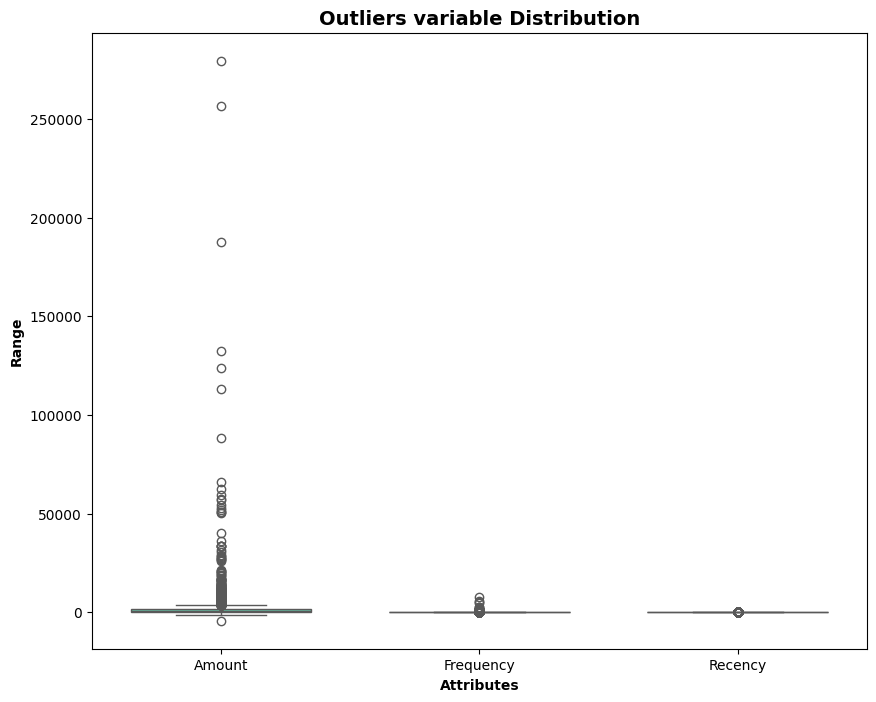

In [19]:
#Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount', 'Frequency', 'Recency']

plt.rcParams['figure.figsize'] = [10,8]

sns.boxplot(data = rfm[attributes], orient="v", palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers variable Distribution", fontsize=14, fontweight='bold')

plt.ylabel("Range", fontweight='bold')
plt.xlabel("Attributes", fontweight="bold")

In [20]:
#Removing (statistical) outliers for Amount

Q1=rfm.Amount.quantile(0.05)

Q3=rfm.Amount.quantile(0.95)

IQR= Q3-Q1

rfm=rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

#Removing (statistical) outliers for Recency

Q1=rfm.Recency.quantile(0.05)

Q3=rfm.Recency.quantile(0.95)

IQR= Q3-Q1

rfm = rfm[(rfm.Recency >= Q1-1.5* IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

#Removing (statistical) outliers for Frequency

Q1=rfm.Frequency.quantile(0.05)

Q3=rfm.Frequency.quantile(0.95)

IQR=Q3-Q1

rfm=rfm[(rfm.Frequency >= Q1-1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

### Scaling down

In [21]:
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

#Instantiate

scaler = StandardScaler()

#fit_transform

rfm_df_scaled = scaler.fit_transform(rfm_df)

rfm_df_scaled.shape

(4293, 3)

In [22]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)

#rfm_df_scaled

rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency'] #rfm_df_scaled.head()

### Model BUilding

In [23]:
kmeans = KMeans(n_clusters=4, max_iter=50)

In [25]:
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=50, n_clusters=4)

In [28]:
kmeans.labels_

array([1, 3, 0, ..., 1, 0, 0], dtype=int32)

In [29]:
set(kmeans.labels_)

{0, 1, 2, 3}

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

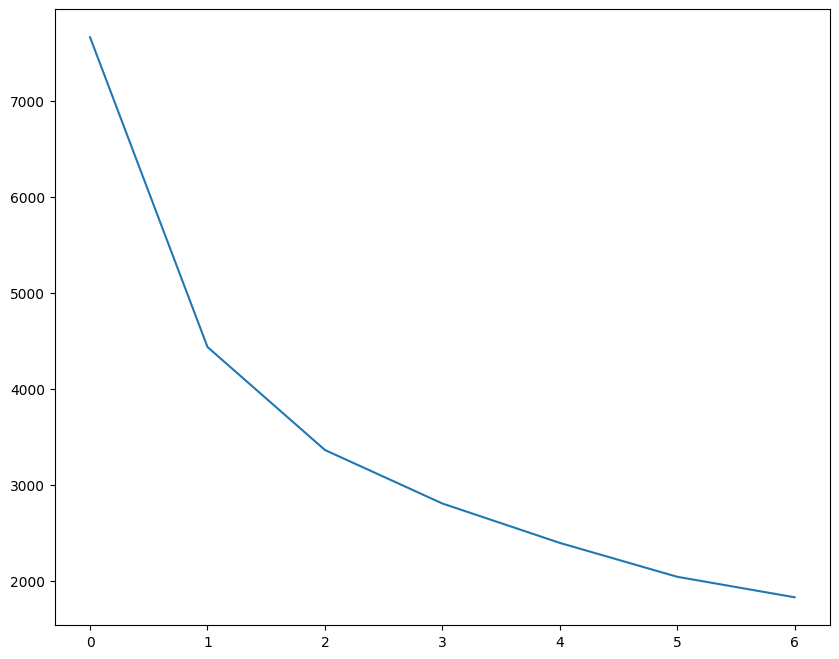

In [30]:
#Elbow Curve to get right number of clusters

ssd = []

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
  kmeans= KMeans(n_clusters=num_clusters, max_iter=50)
  kmeans.fit(rfm_df_scaled)

  ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters plt.plot(ssd)
plt.plot(ssd)

In [31]:
kmeans = KMeans(n_clusters=3, max_iter=400)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=400, n_clusters=3)

In [34]:
filename='kmeans_model.pkl'
import pickle
with open('kmeans_saved_model','wb') as file:
  pickle.dump(kmeans, file)
file.close()
pickle.dump(kmeans, open('kmeans_model.pkl','wb'))

In [35]:
kmeans.labels_

array([2, 0, 1, ..., 2, 1, 1], dtype=int32)

In [36]:
rfm['Cluster_Id'] = kmeans.predict(rfm_df_scaled)
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


<Axes: xlabel='Cluster_Id', ylabel='Amount'>

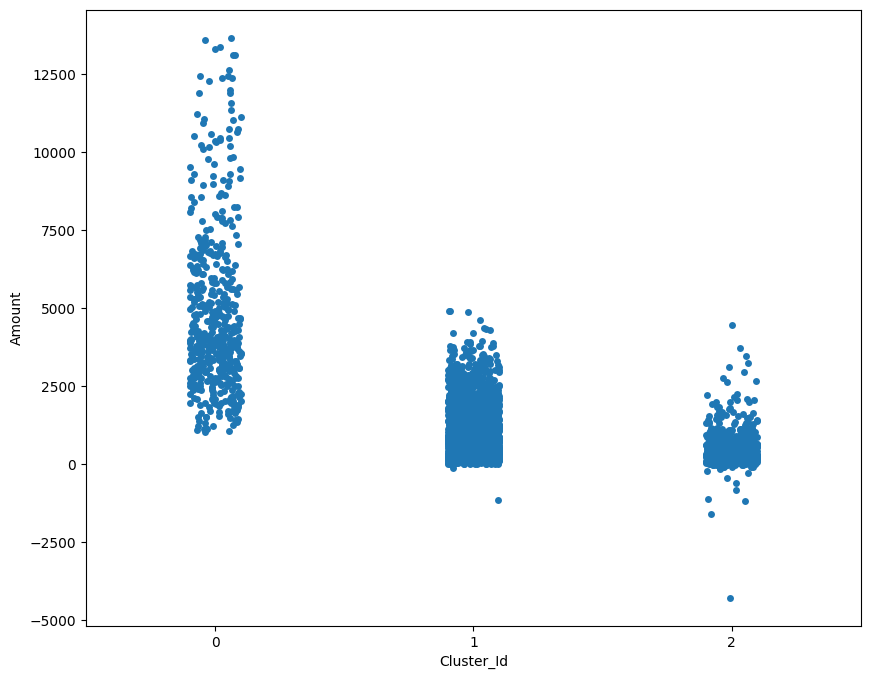

In [37]:
sns.stripplot(x='Cluster_Id' , y='Amount' , data=rfm)

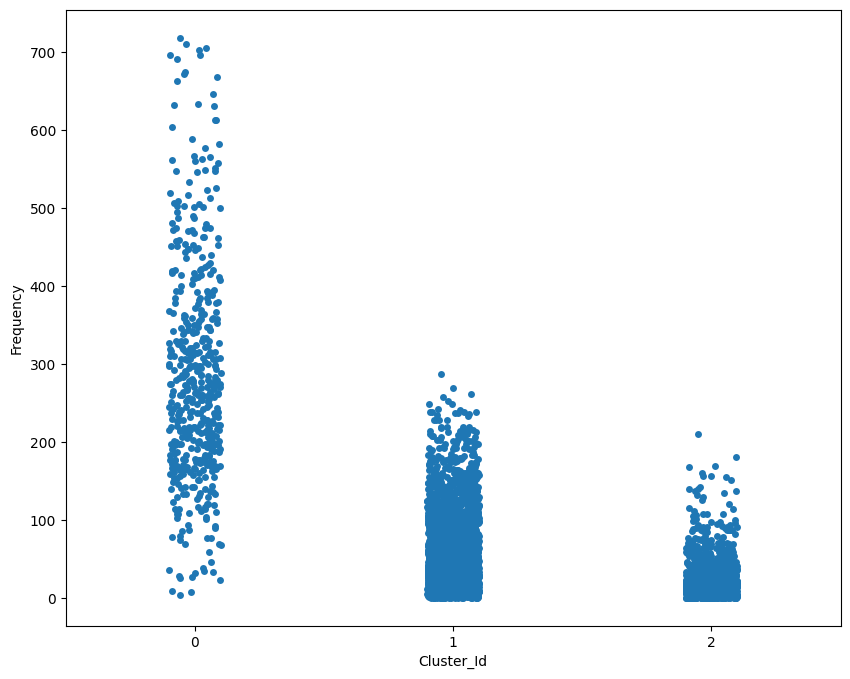

In [38]:
# Box plot to visualise Cluster Id vs Frequency

sns.stripplot(x='Cluster_Id' , y='Frequency' , data=rfm)
plt.savefig("stripplot.png")

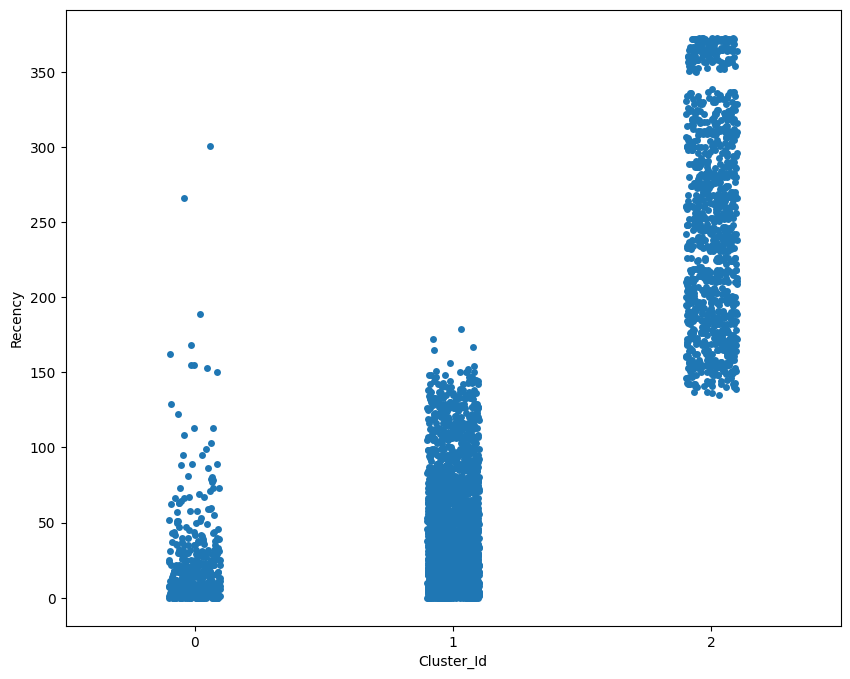

In [39]:
# Box plot to visualise Cluster Id vs Frequency

sns.stripplot(x='Cluster_Id' , y='Recency' , data=rfm)
plt.savefig("Cluster_IdRecency.png")